In [1]:
from collections import Counter

import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report, f1_score)
from sklearn.feature_selection import RFECV

import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

import lightgbm as lgb
import xgboost as xgb

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from tqdm.notebook import tqdm

import warnings
warnings.simplefilter('ignore')

In [2]:
# Carrega a base de dados
data = pd.read_csv('./_data/dataset_2021-5-26-10-14.csv', sep='\t', 
                   encoding='utf-8', na_values='missing')

# Remove a variável "participacao_falencia_valor" pois, de acordo com a 
# análise exploratória, não possui valores
data.drop('participacao_falencia_valor', axis='columns', inplace=True)

In [3]:
# Exibe as dimensões da base de dados
print(f'A base de dados possui {data.shape[0]:,} linhas e {data.shape[1]} colunas.'.replace(',', '.'))

A base de dados possui 117.273 linhas e 21 colunas.


In [4]:
# Separa a base de dados: 80% de dados para teste e 20% dos dados para validação
train_data, test_data = train_test_split(data, 
                                         test_size=0.2, 
                                         stratify=data['default'], # matém a distribuição proporcional à variável alvo
                                         random_state=0)

print(f'A base de treino possui {train_data.shape[0]:,} linhas e {train_data.shape[1]} colunas.'.replace(',', '.'), 
      f'A base de teste possui {test_data.shape[0]:,} linhas e {test_data.shape[1]} colunas.'.replace(',', '.'), sep='\n')

A base de treino possui 93.818 linhas e 21 colunas.
A base de teste possui 23.455 linhas e 21 colunas.


In [5]:
# Separa as variáveis preditoras da variável alvo
X = train_data.drop('default', axis='columns')
y = train_data['default']

# Sanity check
X.shape, y.shape

((93818, 20), (93818,))

## Construção do pipeline de treinamento e validação

In [6]:
%%time
# Modelos que serão avaliados
models = [
  ('Logistic Regression', LogisticRegression(random_state=0, max_iter=1_000)),
  ('KNN', KNeighborsClassifier()),
  ('Decision Tree', DecisionTreeClassifier(random_state=0)),
  ('HistGradient', HistGradientBoostingClassifier(random_state=0)),
  ('Random Forest', RandomForestClassifier(random_state=0)),
  ('XGBoost', xgb.XGBClassifier(random_state=0, n_jobs=-1)),
  ('LightGBM', lgb.LGBMClassifier(random_state=0, n_jobs=-1)),
]

for name, model in tqdm(models):
    
    # Seleciona as features numéricas
    num_features = make_column_selector(dtype_include=np.number)

    # Seleciona as features categóricas
    cat_features = make_column_selector(dtype_exclude=np.number)
    
    # Pré-processamento das variáveis
    preprocessing = make_column_transformer(
        (ce.TargetEncoder(), cat_features),  # transforma as features categóricas em numéricas, 
                                             # tratando os valores faltantes.
        (StandardScaler(), num_features),    # padronização das features numéricas.
    )
    
    # Pipeline final
    pipe = make_pipeline(preprocessing,
                         SMOTE(), # geração de dados sintéticos, a fim de balancear a base de dados
                         model)
    
    # Validação cruzada
    scores = cross_val_score(pipe, X, y, scoring='f1', cv=10, error_score='raise')

    # Exibe o resultado do treinamento
    print(f'F1 score: {scores.mean():.4f} (+/- {scores.std():.4f}), modelo: {name}.')

  0%|          | 0/7 [00:00<?, ?it/s]

F1 score: 0.4343 (+/- 0.0058), modelo: Logistic Regression.
F1 score: 0.4805 (+/- 0.0047), modelo: KNN.
F1 score: 0.5560 (+/- 0.0070), modelo: Decision Tree.
F1 score: 0.6306 (+/- 0.0121), modelo: HistGradient.
F1 score: 0.6903 (+/- 0.0101), modelo: Random Forest.
F1 score: 0.7043 (+/- 0.0132), modelo: XGBoost.
F1 score: 0.6323 (+/- 0.0101), modelo: LightGBM.
Wall time: 16min 50s


> O modelo `XGBoost` apresentou melhor resultado de acordo com a métrica escolhida.

In [7]:
%%time
# Calcula o valor do parâmetro "scale_pos_weight" - para dados desbalanceados
counter = Counter(y)
scale_pos_weight = np.sqrt(counter[0] / counter[1])

model = xgb.XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight, n_jobs=-1)

num_features = make_column_selector(dtype_include=np.number)

cat_features = make_column_selector(dtype_exclude=np.number)
    
preprocessing = make_column_transformer(
    (ce.TargetEncoder(), cat_features),
    (MinMaxScaler(), num_features),
)
    
pipe = make_pipeline(preprocessing, 
                     model)
    
scores = cross_val_score(pipe, X, y, scoring='f1', cv=10, error_score='raise')

print(f'F1 score: {scores.mean():.4f} (+/- {scores.std():.4f}).')

F1 score: 0.7331 (+/- 0.0128).
Wall time: 30.3 s


## Seleção de _features_

In [8]:
# counter = Counter(y)
# scale_pos_weight = np.sqrt(counter[0] / counter[1])

# model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=0, n_jobs=-1)

# num_features = make_column_selector(dtype_include=np.number)
# cat_features = make_column_selector(dtype_exclude=np.number)

# preprocessing = make_column_transformer(
#     (ce.TargetEncoder(), cat_features),
#     (MinMaxScaler(), num_features),
# )

# # Instancia um objeto RFECV para seleção recursiva de features
# rfecv = RFECV(model, scoring='f1')

# # Pipeline final
# pipe = make_pipeline(preprocessing, RFECV(model), model)

# scores = cross_val_score(pipe, X, y, scoring='f1', cv=10, 
#                          verbose=3, error_score='raise')

# print(f'F1 score: {scores.mean():.4f} (+/- {scores.std():.4f}).')

In [9]:
# # %%time
# pipe.fit(X, y)
# print(f'Número ótimo de features: {pipe["rfecv"].n_features_}'')

In [10]:
# # Exibe o ranking das features de acordo com a seleção recursiva
# pd.DataFrame(pipe['rfecv'].ranking_, index=X.columns, columns=['rank']).sort_values('rank')

## Fine-tuning

In [11]:
%%time
param_grid = {
    'xgbclassifier__learning_rate': np.arange(0.05, 1, 0.05),
    'xgbclassifier__max_depth': np.arange(5, 20, 5),
    'xgbclassifier__n_estimators': np.arange(100, 1000, 100)
}

counter = Counter(y)
scale_pos_weight = np.sqrt(counter[0] / counter[1])

model = xgb.XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight, n_jobs=-1)

num_features = make_column_selector(dtype_include=np.number)

cat_features = make_column_selector(dtype_exclude=np.number)
    
preprocessing = make_column_transformer(
    (ce.TargetEncoder(), cat_features),
    (MinMaxScaler(), num_features),
)
    
pipe = make_pipeline(preprocessing, 
                     model)

# RandomizedSearchCV
xgboost_classifier = RandomizedSearchCV(pipe, param_grid, n_iter=10, scoring='f1', verbose=2, cv=10)
xgboost_classifier.fit(X, y)

# Exibe as métricas
print(f'F1 score: {xgboost_classifier.best_score_:.4f}')
# print(xgboost_classifier.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=900; total time=  19.1s
[CV] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=900; total time=  19.3s
[CV] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=900; total time=  20.0s
[CV] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=900; total time=  19.2s
[CV] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=900; total time=  19.0s
[CV] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=900; total time=  19.2s
[CV] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=5, xgbclassifier__n_estimators=900; total time=  19.3s
[CV] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=5, xgbcl

In [12]:
# Salva o modelo
joblib.dump(xgboost_classifier, 'xgboost_classifier.sav')

['xgboost_classifier.sav']

## Avaliação do modelo

In [13]:
# Carrega o modelo
saved_model = joblib.load('./xgboost_classifier.sav')

In [14]:
# Prepara os dados de teste
X_test = test_data.drop(['default'], axis=1)
y_test = test_data['default']

In [15]:
# Gera predições a partir do modelo treinado
y_pred = saved_model.best_estimator_.predict(X_test)
print(f'F1 score: {f1_score(y_test, y_pred):.4f}')

F1 score: 0.8050


## Matrix de confusão

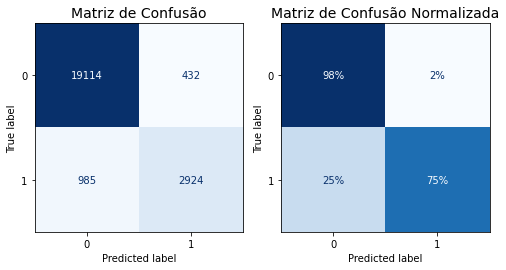

In [20]:
fig, ax = plt.subplots(1, 2, figsize=[7, 7])

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues', ax=ax[0], colorbar=False)
ax[0].set_title('Matriz de Confusão', fontsize=14)

cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm).plot(cmap='Blues', values_format='.0%', 
                                ax=ax[1], colorbar=False)
ax[1].set_title('Matriz de Confusão Normalizada', fontsize=14)

plt.tight_layout();

## _classification report_

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     19546
           1       0.87      0.75      0.80      3909

    accuracy                           0.94     23455
   macro avg       0.91      0.86      0.88     23455
weighted avg       0.94      0.94      0.94     23455

